In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

from monai.config import print_config
from monai.data import DataLoader
from generative.networks.nets import DiffusionModelUNet

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
from PIL import Image
from torchvision import transforms
import torchvision
import pandas as pd
from skimage.metrics import structural_similarity as ssim_fn
import wandb


from torch import nn


from tqdm import trange, tqdm



print_config()

/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


MONAI version: 1.3.2
Numpy version: 2.0.1
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/miniconda3/envs/medical/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.0
scipy version: 1.15.3
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INST

## Training using Pix2Pix 2D

In [3]:
class UnifiedBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None, split="train", seed=42):
        assert split in ["train", "val", "test"], "split must be 'train', 'val' or 'test'"
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        self.samples = self._create_file_pairs()
        self._split_dataset()

    def _create_file_pairs(self):
        t1_dir = os.path.join(self.root_dir, "t1")
        t2_dir = os.path.join(self.root_dir, "t2")

        t1_files = set(os.listdir(t1_dir))
        t2_files = set(os.listdir(t2_dir))
        common_files = list(t1_files.intersection(t2_files))
        common_files.sort()

        pairs = [(os.path.join(t1_dir, fname), os.path.join(t2_dir, fname)) for fname in common_files]
        return pairs

    def _split_dataset(self):
        random.seed(self.seed)
        random.shuffle(self.samples)

        n_total = len(self.samples)
        n_train = int(n_total * 0.80)
        n_val = int(n_total * 0.05)
        n_test = n_total - n_train - n_val

        if self.split == "train":
            self.samples = self.samples[:n_train]
        elif self.split == "val":
            self.samples = self.samples[n_train:n_train + n_val]
        elif self.split == "test":
            self.samples = self.samples[n_train + n_val:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t1_path, t2_path = self.samples[idx]
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")

        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)

        return {
            "t1": t1_image,
            "t2": t2_image,
            "filename": os.path.basename(t1_path)
        }

In [3]:
DATAPATH = DATAPATH = '/home/andrea_moschetto/FlowMatching-MREConversion/data'
OUTPUT_DIR = "/home/andrea_moschetto/FlowMatching-MREConversion/outputs"
CHECKPOINTS_PATH = '/home/andrea_moschetto/FlowMatching-MREConversion/baseline_checkpoints'

In [18]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])
BATCH_SIZE = 128
NUM_WORKERS = 4
train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [4]:
import functools


class UnetSkipConnectionBlock2D(nn.Module):
    def __init__(self, outer_nc, inner_nc, in_channels=None, submodule=None, outermost=False, innermost=False, norm_layer=nn.InstanceNorm2d, use_dropout=True):
        super(UnetSkipConnectionBlock2D, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if in_channels is None:
            in_channels = outer_nc
        downconv = nn.Conv2d(in_channels, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
        
class UNetGenerator2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_downs=7, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=True):
        super(UNetGenerator2D, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock2D(ngf * 8, ngf * 8, in_channels=None, submodule=None, norm_layer=norm_layer, innermost=True)  # innermost
        for i in range(num_downs - 5): # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock2D(ngf * 8, ngf * 8, in_channels=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock2D(ngf * 4, ngf * 8, in_channels=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock2D(ngf * 2, ngf * 4, in_channels=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock2D(ngf, ngf * 2, in_channels=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock2D(out_channels, ngf, in_channels=in_channels, submodule=unet_block, outermost=True, norm_layer=norm_layer)

    def forward(self, input):
        return self.model(input)
    

class NLayerDiscriminator2D(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d):
        super(NLayerDiscriminator2D, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4 # kernel width
        padw = 1 # padding width
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)
        


In [5]:
def percnorm(arr, lperc=5, uperc=99.5):
    """
    Remove outlier intensities from a brain component,
    similar to Tukey's fences method.
    """
    upperbound = np.percentile(arr, uperc)
    lowerbound = np.percentile(arr, lperc)
    arr[arr > upperbound] = upperbound
    arr[arr < lowerbound] = lowerbound
    return arr

def normalize(img):
    # img: [C, H, W]
    img = (img - img.min())/ (img.max() - img.min() + 1e-8)
    return img

def preprocess_image(in_tensor_img):
    # tensor_img: [1, H, W]
    img_np = in_tensor_img.squeeze(0).cpu().numpy()  # [H, W]
    img_np = percnorm(img_np)                     # Percentile-based normalization
    out_tensor_image = torch.from_numpy(img_np).unsqueeze(0)  # Back to [1, H, W]
    out_tensor_image = normalize(out_tensor_image)            # 0-1 normalization
    return out_tensor_image.to(in_tensor_img.device)  # [1, 1, H, W]


In [21]:
if not os.path.exists(f'{CHECKPOINTS_PATH}/backups'):
    os.makedirs(f'{CHECKPOINTS_PATH}/backups')

def get_norm_layer():

    norm_layer = functools.partial(nn.InstanceNorm3d, affine=False, track_running_stats=False)

    return norm_layer

# Initialize weights (optional, often helpful for GANs)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
            
def train_GAN(netG: UNetGenerator2D, netD: NLayerDiscriminator2D, train_loader: DataLoader, val_loader: DataLoader, project: str, exp_name: str, notes: str, n_epochs: int = 200, n_epochs_decay: int = 100, lr_g: float = 0.0002, lr_d: float = 0.00005, beta1: float = 0.5, lambda_l1: float = 100.0):
    with wandb.init(
        project=project,
        name=exp_name,
        notes=notes,
        tags=["flow", "brain", "diffusion"],
        config={
            'modelG': netG.__class__.__name__,
            'modelD': netD.__class__.__name__,
            'epochs': n_epochs,
            'n_epochs_decay': n_epochs_decay,
            'batch_size': train_loader.batch_size,
            'num_workers': train_loader.num_workers,
            'optimizer': 'Adam',
            'learning_rate_g': lr_g,
            'learning_rate_d': lr_d,
            'beta1': beta1,
            'lambda_l1': lambda_l1,
            'loss_functions': 'BCEWithLogitsLoss, L1Loss',
            'device': str(torch.cuda.get_device_name(0)
                          if torch.cuda.is_available() else "CPU"),
        }
    ) as run:
        start_time = time.time()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        # --- Models ---
        netG = netG.to(device)
        netD = netD.to(device)
        print("Initializing weights...")
        netG.apply(weights_init)
        netD.apply(weights_init)
        print("Models initialized.")
        
        # --- Loss Functions ---
        criterionGAN = nn.BCEWithLogitsLoss() # Sigmoid is included
        criterionL1 = nn.L1Loss()
        # --- Optimizers ---
        optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
        optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
        # --- Learning Rate Schedulers ---
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 - (n_epochs - n_epochs_decay)) / float(n_epochs_decay + 1)
            return lr_l
        schedulerG = optim.lr_scheduler.LambdaLR(optimizerG, lr_lambda=lambda_rule)
        schedulerD = optim.lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda_rule)
        
        # --- Training Loop ---
        print("Starting Training Loop...")
        best_val_g_l1_loss = float('inf')
        best_path_g = None
        best_path_d = None
        for epoch in trange(n_epochs, desc="Epochs"):
            epoch_start_time = time.time()
            netG.train()
            netD.train()

            epoch_loss_g = 0
            epoch_loss_d = 0
            epoch_loss_g_gan = 0
            epoch_loss_g_l1 = 0
            for i, batch_data in enumerate(train_loader):
                real_A = batch_data['t1'].to(device)
                real_B = batch_data['t2'].to(device)
                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizerD.zero_grad()
                # Real images
                # Discriminator input: concatenate T1 (real_A) and real T2 (real_B)
                real_AB = torch.cat((real_A, real_B), 1)
                pred_real = netD(real_AB)
                # Label smoothing: use 0.9 for real instead of 1.0
                target_real = torch.full(pred_real.shape, 0.9 if torch.rand(1).item() > 0.05 else 1.0, device=device, dtype=torch.float32) # Small chance of flipping for robustness
                loss_D_real = criterionGAN(pred_real, target_real)

                # Fake images
                fake_B = netG(real_A).detach() # Detach to avoid backprop to G here
                # Discriminator input: concatenate T1 (real_A) and fake T2 (fake_B)
                fake_AB = torch.cat((real_A, fake_B), 1)
                pred_fake = netD(fake_AB)
                # Label smoothing: use 0.1 for fake instead of 0.0
                target_fake = torch.full(pred_fake.shape, 0.1 if torch.rand(1).item() > 0.05 else 0.0, device=device, dtype=torch.float32)
                loss_D_fake = criterionGAN(pred_fake, target_fake)

                # Total discriminator loss
                loss_D = (loss_D_real + loss_D_fake) * 0.5
                loss_D.backward()
                optimizerD.step()

                epoch_loss_d += loss_D.item()
                
                # -----------------
                #  Train Generator
                # -----------------
                optimizerG.zero_grad()

                # Generate fake T2
                fake_B_for_G = netG(real_A)
                # Discriminator input for G's adversarial loss
                fake_AB_for_G = torch.cat((real_A, fake_B_for_G), 1)
                pred_fake_G = netD(fake_AB_for_G)
                # Generator wants discriminator to think fake images are real
                target_real_for_G = torch.ones_like(pred_fake_G, device=device, dtype=torch.float32) # No smoothing for G's target
                loss_G_GAN = criterionGAN(pred_fake_G, target_real_for_G)

                # L1 loss (reconstruction loss)
                loss_G_L1 = criterionL1(fake_B_for_G, real_B) * lambda_l1

                # Total generator loss
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizerG.step()

                epoch_loss_g += loss_G.item()
                epoch_loss_g_gan += loss_G_GAN.item()
                epoch_loss_g_l1 += loss_G_L1.item()

            # Update learning rates
            schedulerG.step()
            schedulerD.step()
            
            # --- Training Losses ---
            avg_loss_d = epoch_loss_d / len(train_loader)
            avg_loss_g = epoch_loss_g / len(train_loader)
            avg_loss_g_gan = epoch_loss_g_gan / len(train_loader)
            avg_loss_g_l1 = epoch_loss_g_l1 / len(train_loader)
            
            # -----------------------
            #  Validation Phase
            # -----------------------
            netG.eval()
            netD.eval()
            val_loss_g = 0
            val_loss_d = 0
            val_loss_g_gan = 0
            val_loss_g_l1 = 0

            with torch.no_grad():
                for val_batch in val_loader:
                    real_A = val_batch['t1'].to(device)
                    real_B = val_batch['t2'].to(device)

                    # --- Discriminator ---
                    real_AB = torch.cat((real_A, real_B), 1)
                    pred_real = netD(real_AB)
                    target_real = torch.ones_like(pred_real, device=device)
                    loss_D_real = criterionGAN(pred_real, target_real)

                    fake_B = netG(real_A)
                    fake_AB = torch.cat((real_A, fake_B), 1)
                    pred_fake = netD(fake_AB)
                    target_fake = torch.zeros_like(pred_fake, device=device)
                    loss_D_fake = criterionGAN(pred_fake, target_fake)

                    loss_D = (loss_D_real + loss_D_fake) * 0.5
                    val_loss_d += loss_D.item()

                    # --- Generator ---
                    pred_fake_G = netD(fake_AB)
                    target_real_for_G = torch.ones_like(pred_fake_G, device=device)
                    loss_G_GAN = criterionGAN(pred_fake_G, target_real_for_G)
                    loss_G_L1 = criterionL1(fake_B, real_B) * lambda_l1
                    loss_G = loss_G_GAN + loss_G_L1

                    val_loss_g += loss_G.item()
                    val_loss_g_gan += loss_G_GAN.item()
                    val_loss_g_l1 += loss_G_L1.item()

            # --- Average Validation Losses ---
            avg_val_loss_d = val_loss_d / len(val_loader)
            avg_val_loss_g = val_loss_g / len(val_loader)
            avg_val_loss_g_gan = val_loss_g_gan / len(val_loader)
            avg_val_loss_g_l1 = val_loss_g_l1 / len(val_loader)

            epoch_duration = time.time() - epoch_start_time
                    
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "loss_G": avg_loss_g,
                    "loss_G_GAN": avg_loss_g_gan,
                    "loss_G_L1": avg_loss_g_l1,
                    "loss_D": avg_loss_d,
                    "val_loss_G": avg_val_loss_g,
                    "val_loss_G_GAN": avg_val_loss_g_gan,
                    "val_loss_G_L1": avg_val_loss_g_l1,
                    "val_loss_D": avg_val_loss_d,
                    "lr_G": optimizerG.param_groups[0]['lr'],
                    "lr_D": optimizerD.param_groups[0]['lr'],
                    "epoch_time_minutes": epoch_duration // 60
                }
            )
            if epoch % 5 == 0 or (epoch + 1) == n_epochs or val_loss_g_l1 < best_val_g_l1_loss:
                # Log sample images
                with torch.no_grad():
                    sample_batch = next(iter(val_loader))
                    sample_real_A = sample_batch['t1'][0].unsqueeze(0).to(device)
                    sample_real_B = sample_batch['t2'][0].to(device)
                    sample_fake_B = netG(sample_real_A)
                    imgs = torch.stack([sample_real_A.squeeze(0),
                                        sample_real_B,
                                        preprocess_image(sample_fake_B.squeeze(0))], dim=0)
                    grid = torchvision.utils.make_grid(imgs, nrow=3, scale_each=True)
                    wandb.log({'each5e_generation': wandb.Image(grid, caption=f'Epoch {epoch + 1}')})
                
                if val_loss_g_l1 < best_val_g_l1_loss:
                    # Save best models
                    best_val_g_l1_loss = val_loss_g_l1
                    path_g = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{epoch+1}__generator_best.pth'
                    path_d = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{epoch+1}__discriminator_best_g.pth' # Note: discriminato is the one that was trained with the best generator
                    torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': netG.state_dict(),
                        'optimizer_state_dict': optimizerG.state_dict(),
                    }, path_g)
                    torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': netD.state_dict(),
                        'optimizer_state_dict': optimizerD.state_dict(),
                    }, path_d)
                    if best_path_g is not None and os.path.exists(best_path_g):
                        os.remove(best_path_g)
                    if best_path_d is not None and os.path.exists(best_path_d):
                        os.remove(best_path_d)
                    best_path_g = path_g
                    best_path_d = path_d
                else:    
                    # Save backups every 5 epochs
                    torch.save({
                            'epoch': epoch+1,
                            'model_state_dict': netG.state_dict(),
                            'optimizer_state_dict': optimizerG.state_dict(),
                        }, f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{epoch+1}__generator.pth')
                    torch.save({
                            'epoch': epoch+1,
                            'model_state_dict': netD.state_dict(),
                            'optimizer_state_dict': optimizerD.state_dict(),
                        }, f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{epoch+1}__discriminator.pth')
        wandb.log({"total_running_hours": (time.time() - start_time) // 3600})
        return best_path_g, best_path_d
        
        

In [6]:
@torch.no_grad()
def generate_and_save_predictions(generator: UNetGenerator2D | DiffusionModelUNet, test_loader: DataLoader, device: str, output_dir: str = OUTPUT_DIR, just_one_batch: bool = False):
    os.makedirs(output_dir, exist_ok=True)
    generator.eval()

    all_outputs = []

    for idx, batch in enumerate(tqdm(test_loader, desc="Generating Predictions")):
        with torch.no_grad():
            real_A = batch["t1"].to(device)  # [B, 1, H, W]
            real_B = batch["t2"].to(device)  # [B, 1, H, W]
            filenames = batch["filename"]  # list of strings (length B)
            # Generate fake T2 images
            if isinstance(generator, DiffusionModelUNet):
                gen_images = generator(x=real_A, timesteps=torch.zeros(real_A.shape[0], device=device))
            else:
                gen_images = generator(real_A)  # [B, 1, H, W]

            
        for i in range(real_A.size(0)):
            sample = {
                "filename": filenames[i],
                "input": real_A[i].cpu(),         # torch.Tensor [1, H, W]
                "target": real_B[i].cpu(),
                "prediction": gen_images[i].cpu()
            }

            torch.save(sample, os.path.join(output_dir, f"{filenames[i]}.pt"))
            all_outputs.append(sample)
            
        if just_one_batch:
            break
        wandb.log({"prediction_progress": idx})

    return all_outputs

In [7]:
class PredictionDataset(Dataset):
    def __init__(self, directory):
        super().__init__()
        self.directory = directory
        self.files = sorted([
            f for f in os.listdir(directory) if f.endswith('.pt')
        ])
        if not self.files:
            raise ValueError(f"No .pt files found in directory: {directory}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self[i] for i in range(*idx.indices(len(self)))]
        file_path = os.path.join(self.directory, self.files[idx])
        data = torch.load(file_path)
        pred = data["prediction"]       # expected shape: [1, H, W] or [C, H, W]
        gt = data["target"]
        return pred, gt


In [8]:
def compute_ssim_from_dataset(dataset):
    ssim_scores = []
    mse_scores = []

    example_pred = None
    example_gt = None

    for i in range(len(dataset)):
        pred, gt = dataset[i]  # tensors [1, H, W]

        # Convert to numpy and squeeze channel
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = gt.squeeze().cpu().numpy()

        pred_np = normalize(percnorm(pred_np))
        gt_np = normalize(percnorm(gt_np))

        # Compute SSIM
        ssim_val = ssim_fn(pred_np, gt_np, data_range=1.0)
        ssim_scores.append(ssim_val)

        # Compute MSE
        mse_val = F.mse_loss(pred, gt).item()
        mse_scores.append(mse_val)

        # Store one example for visualization
        if i == 4 and example_pred is None:
            example_pred = pred_np
            example_gt = gt_np

    ssim_scores = np.array(ssim_scores)
    mse_scores = np.array(mse_scores)
    
    summary = pd.DataFrame({
        "Metric": ["SSIM", "MSE"],
        "Mean": [ssim_scores.mean(), mse_scores.mean()],
        "Variance": [ssim_scores.var(), mse_scores.var()]
    })

    # Visualize example
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(example_gt, cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(example_pred, cmap='gray')
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.suptitle("Example Comparison")
    plt.tight_layout()
    plt.show()

    return summary

In [6]:
import functools
def get_norm_layer():
    norm_layer = functools.partial(nn.InstanceNorm3d, affine=False, track_running_stats=False)
    return norm_layer

norm_layer_g = get_norm_layer()
norm_layer_d = get_norm_layer()

netG = UNetGenerator2D(
    in_channels=1, 
    out_channels=1, 
    num_downs=5, 
    ngf=64, 
    norm_layer=norm_layer_g, 
    use_dropout=False
)

netD = NLayerDiscriminator2D(
    input_nc=2,
    ndf=64,
    n_layers=3,
    norm_layer=norm_layer_d
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_name = "pix2pix-t1t2-brain300e"
best_path_g, best_path_d = train_GAN(
    netG=netG,
    netD=netD,
    train_loader=train_loader,
    val_loader=val_loader,
    project="FlowMatching-Baselines",
    exp_name=exp_name,
    notes="Baseline Pix2Pix for T1-T2 conversion",
    n_epochs=300,
    n_epochs_decay=100,
    lr_g=0.0002,
    lr_d=0.00005,
    beta1=0.5,
    lambda_l1=100.0
)
checkpoint = torch.load(best_path_g, map_location=device)
netG.load_state_dict(checkpoint['model_state_dict'])
netG.to(device)



Using device: cuda
Initializing weights...
Models initialized.
Starting Training Loop...


Epochs:   0%|                                                                    | 0/300 [00:00<?, ?it/s]/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
Epochs:   5%|███                                                      | 16/300 [09:31<2:52:03, 36.35s/it]

Generating Predictions:   0%|                                                      | 0/3 [00:00<?, ?it/s]/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
Generating Predictions: 100%|██████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]
/tmp/ipykernel_100486/159395810.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

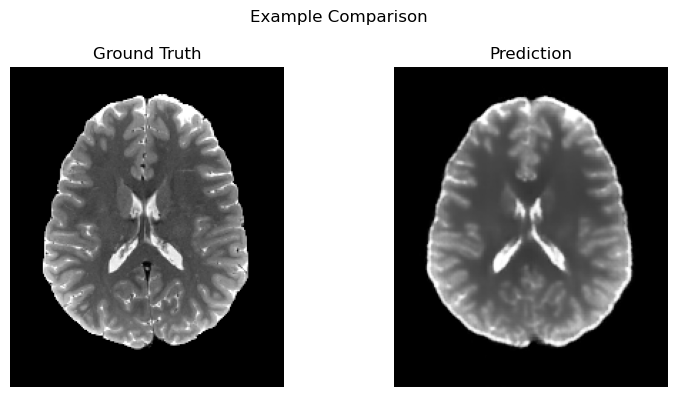

eval/mse_mean,▁
eval/mse_var,▁
eval/ssim_mean,▁
eval/ssim_var,▁
prediction_progress,▁▅█
eval/mse_mean,0.00674
eval/mse_var,0.0
eval/ssim_mean,0.80271
eval/ssim_var,0.00077
prediction_progress,2


In [ ]:
with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    generate_and_save_predictions(
        generator=netG,
        test_loader=test_loader,
        device=device,
        output_dir=f'{OUTPUT_DIR}/{exp_name}',
        just_one_batch=False)
    out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}')

    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/metrics": wandb.Table(dataframe=summary)})
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/mse_mean": summary["Mean"][1]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/mse_var": summary["Variance"][1]})

In [33]:
summary

,Metric,Mean,Variance
0,SSIM,0.802714,0.000773
1,MSE,0.006743,0.000004


/tmp/ipykernel_100486/48971340.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_path_g, map_location=device)


Generating Predictions:   0%|                                                      | 0/3 [00:00<?, ?it/s]/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
Generating Predictions: 100%|██████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]
/tmp/ipykernel_100486/159395810.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

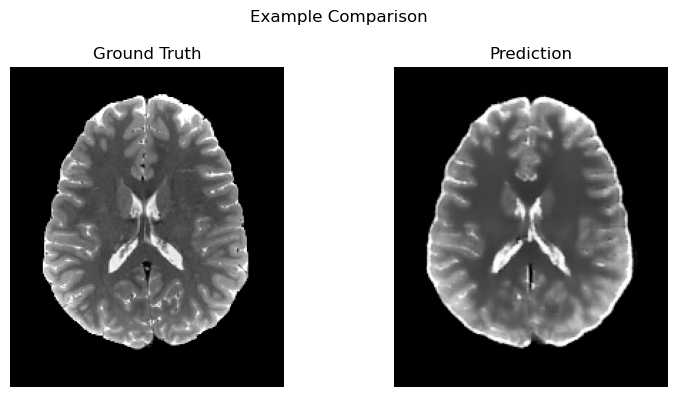

eval/mse_mean,▁
eval/mse_var,▁
eval/ssim_mean,▁
eval/ssim_var,▁
prediction_progress,▁▅█
eval/mse_mean,0.00772
eval/mse_var,0.0
eval/ssim_mean,0.81461
eval/ssim_var,0.00077
prediction_progress,2


,Metric,Mean,Variance
0,SSIM,0.814610,0.000765
1,MSE,0.007718,0.000004


In [ ]:
best_path_g = '/home/andrea_moschetto/FlowMatching-MREConversion/baseline_checkpoints/backups/checkpoint_pix2pix-t1t2-brain300e_300__generator.pth'
checkpoint = torch.load(best_path_g, map_location=device)
netG.load_state_dict(checkpoint['model_state_dict'])
netG.to(device)

with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}300',
    notes="Evaluation of the diffusion model on the test set.",
):
    generate_and_save_predictions(
        generator=netG,
        test_loader=test_loader,
        device=device,
        output_dir=f'{OUTPUT_DIR}/{exp_name}300',
        just_one_batch=False)
    out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}300')

    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/metrics": wandb.Table(dataframe=summary)})
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/mse_mean": summary["Mean"][1]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/mse_var": summary["Variance"][1]})
summary

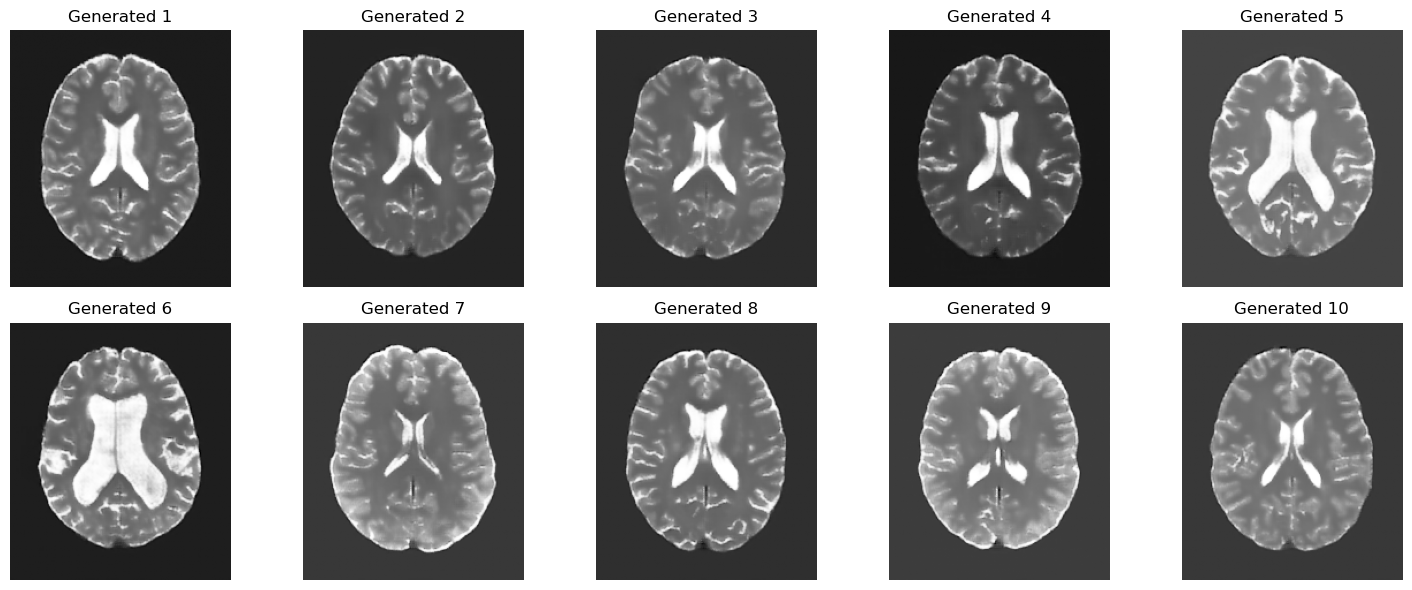

In [ ]:
# Prendi un batch dal test set
sample_batch = next(iter(test_loader))
real_A_batch = sample_batch["t1"][:10].to(device)  # Prendi solo i primi 10
H, W = real_A_batch.shape[-2:]

netG.eval()
with torch.no_grad():
    # Genera le immagini
    fake_B_batch = netG(real_A_batch)

# Porta su CPU per visualizzazione
real_A_batch = real_A_batch.cpu().numpy()
fake_B_batch = fake_B_batch.cpu().numpy()

# Visualizza le immagini generate in una griglia 2x5
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_B_batch[i].squeeze(), cmap='gray')
    plt.title(f"Generated {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


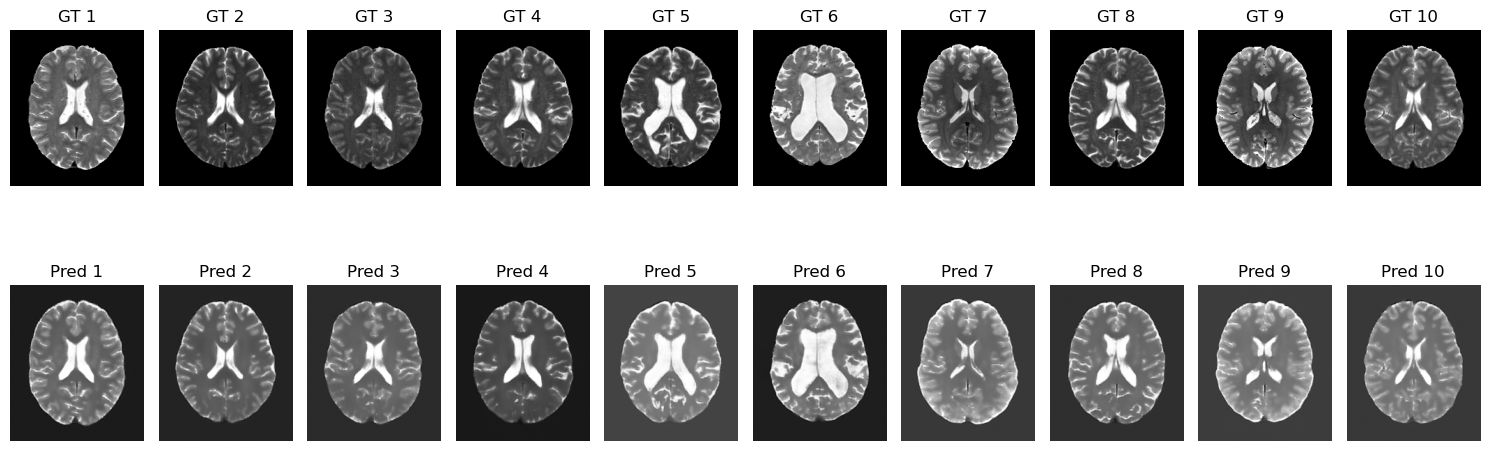

In [ ]:
# Estrai un batch dal test_loader
sample_batch = next(iter(test_loader))
real_A_batch = sample_batch["t1"][:10].to(device)  # T1 input
real_B_batch = sample_batch["t2"][:10].to(device)  # T2 ground truth
netG.eval()

with torch.no_grad():
    fake_B_batch = netG(real_A_batch)  # T2 predetto

# Porta su CPU e converti in numpy
real_B_batch = real_B_batch.cpu().numpy()
fake_B_batch = fake_B_batch.cpu().numpy()

# Visualizza in griglia 2 righe x 5 colonne: GT sopra, predizione sotto
plt.figure(figsize=(15, 6))
for i in range(10):
    # Riga superiore: ground truth
    plt.subplot(2, 10, i + 1)
    plt.imshow(real_B_batch[i].squeeze(), cmap='gray')
    plt.title(f"GT {i+1}")
    plt.axis("off")

    # Riga inferiore: generato
    plt.subplot(2, 10, i + 11)
    plt.imshow(fake_B_batch[i].squeeze(), cmap='gray')
    plt.title(f"Pred {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Using Unet as a Generator

In [9]:
if not os.path.exists(f'{CHECKPOINTS_PATH}/backups'):
    os.makedirs(f'{CHECKPOINTS_PATH}/backups')

def get_norm_layer():

    norm_layer = functools.partial(nn.InstanceNorm3d, affine=False, track_running_stats=False)

    return norm_layer

# Initialize weights (optional, often helpful for GANs)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
            
def train_GAN(unetG: DiffusionModelUNet, netD: NLayerDiscriminator2D, train_loader: DataLoader, val_loader: DataLoader, project: str, exp_name: str, notes: str, n_epochs: int = 200, n_epochs_decay: int = 100, lr_g: float = 0.0002, lr_d: float = 0.00005, beta1: float = 0.5, lambda_l1: float = 100.0):
    with wandb.init(
        project=project,
        name=exp_name,
        notes=notes,
        tags=["flow", "brain", "diffusion"],
        config={
            'modelG': unetG.__class__.__name__,
            'modelD': netD.__class__.__name__,
            'epochs': n_epochs,
            'n_epochs_decay': n_epochs_decay,
            'batch_size': train_loader.batch_size,
            'num_workers': train_loader.num_workers,
            'optimizer': 'Adam',
            'learning_rate_g': lr_g,
            'learning_rate_d': lr_d,
            'beta1': beta1,
            'lambda_l1': lambda_l1,
            'loss_functions': 'BCEWithLogitsLoss, L1Loss',
            'device': str(torch.cuda.get_device_name(0)
                          if torch.cuda.is_available() else "CPU"),
        }
    ) as run:
        start_time = time.time()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        # --- Models ---
        unetG = unetG.to(device)
        netD = netD.to(device)
        print("Initializing weights...")
        # unetG.apply(weights_init)
        netD.apply(weights_init)
        print("Models initialized.")
        
        # --- Loss Functions ---
        criterionGAN = nn.BCEWithLogitsLoss() # Sigmoid is included
        criterionL1 = nn.L1Loss()
        # --- Optimizers ---
        optimizerG = optim.Adam(unetG.parameters(), lr=lr_g, betas=(beta1, 0.999))
        optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
        # --- Learning Rate Schedulers ---
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 - (n_epochs - n_epochs_decay)) / float(n_epochs_decay + 1)
            return lr_l
        schedulerG = optim.lr_scheduler.LambdaLR(optimizerG, lr_lambda=lambda_rule)
        schedulerD = optim.lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda_rule)
        
        # --- Training Loop ---
        print("Starting Training Loop...")
        best_val_g_l1_loss = float('inf')
        best_path_g = None
        best_path_d = None
        for epoch in trange(n_epochs, desc="Epochs"):
            epoch_start_time = time.time()
            unetG.train()
            netD.train()

            epoch_loss_g = 0
            epoch_loss_d = 0
            epoch_loss_g_gan = 0
            epoch_loss_g_l1 = 0
            for i, batch_data in enumerate(train_loader):
                real_A = batch_data['t1'].to(device)
                real_B = batch_data['t2'].to(device)
                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizerD.zero_grad()
                # Real images
                # Discriminator input: concatenate T1 (real_A) and real T2 (real_B)
                real_AB = torch.cat((real_A, real_B), 1)
                pred_real = netD(real_AB)
                # Label smoothing: use 0.9 for real instead of 1.0
                target_real = torch.full(pred_real.shape, 0.9 if torch.rand(1).item() > 0.05 else 1.0, device=device, dtype=torch.float32) # Small chance of flipping for robustness
                loss_D_real = criterionGAN(pred_real, target_real)

                # Fake images
                # fake_B = netG(real_A).detach() # Detach to avoid backprop to G here
                fake_B = unetG(x=real_A, timesteps=torch.zeros(real_A.shape[0], device=device)).detach() # Detach to avoid backprop to G here
                
                # Discriminator input: concatenate T1 (real_A) and fake T2 (fake_B)
                fake_AB = torch.cat((real_A, fake_B), 1)
                pred_fake = netD(fake_AB)
                # Label smoothing: use 0.1 for fake instead of 0.0
                target_fake = torch.full(pred_fake.shape, 0.1 if torch.rand(1).item() > 0.05 else 0.0, device=device, dtype=torch.float32)
                loss_D_fake = criterionGAN(pred_fake, target_fake)

                # Total discriminator loss
                loss_D = (loss_D_real + loss_D_fake) * 0.5
                loss_D.backward()
                optimizerD.step()

                epoch_loss_d += loss_D.item()
                
                # -----------------
                #  Train Generator
                # -----------------
                optimizerG.zero_grad()

                # Generate fake T2
                fake_B_for_G = unetG(x=real_A, timesteps=torch.zeros(real_A.shape[0], device=device))
                # Discriminator input for G's adversarial loss
                fake_AB_for_G = torch.cat((real_A, fake_B_for_G), 1)
                pred_fake_G = netD(fake_AB_for_G)
                # Generator wants discriminator to think fake images are real
                target_real_for_G = torch.ones_like(pred_fake_G, device=device, dtype=torch.float32) # No smoothing for G's target
                loss_G_GAN = criterionGAN(pred_fake_G, target_real_for_G)

                # L1 loss (reconstruction loss)
                loss_G_L1 = criterionL1(fake_B_for_G, real_B) * lambda_l1

                # Total generator loss
                loss_G = loss_G_GAN + loss_G_L1
                loss_G.backward()
                optimizerG.step()

                epoch_loss_g += loss_G.item()
                epoch_loss_g_gan += loss_G_GAN.item()
                epoch_loss_g_l1 += loss_G_L1.item()

            # Update learning rates
            schedulerG.step()
            schedulerD.step()
            
            # --- Training Losses ---
            avg_loss_d = epoch_loss_d / len(train_loader)
            avg_loss_g = epoch_loss_g / len(train_loader)
            avg_loss_g_gan = epoch_loss_g_gan / len(train_loader)
            avg_loss_g_l1 = epoch_loss_g_l1 / len(train_loader)
            
            # -----------------------
            #  Validation Phase
            # -----------------------
            unetG.eval()
            netD.eval()
            val_loss_g = 0
            val_loss_d = 0
            val_loss_g_gan = 0
            val_loss_g_l1 = 0

            with torch.no_grad():
                for val_batch in val_loader:
                    real_A = val_batch['t1'].to(device)
                    real_B = val_batch['t2'].to(device)

                    # --- Discriminator ---
                    real_AB = torch.cat((real_A, real_B), 1)
                    pred_real = netD(real_AB)
                    target_real = torch.ones_like(pred_real, device=device)
                    loss_D_real = criterionGAN(pred_real, target_real)

                    fake_B = unetG(x=real_A, timesteps=torch.zeros(real_A.shape[0], device=device))
                    fake_AB = torch.cat((real_A, fake_B), 1)
                    pred_fake = netD(fake_AB)
                    target_fake = torch.zeros_like(pred_fake, device=device)
                    loss_D_fake = criterionGAN(pred_fake, target_fake)

                    loss_D = (loss_D_real + loss_D_fake) * 0.5
                    val_loss_d += loss_D.item()

                    # --- Generator ---
                    pred_fake_G = netD(fake_AB)
                    target_real_for_G = torch.ones_like(pred_fake_G, device=device)
                    loss_G_GAN = criterionGAN(pred_fake_G, target_real_for_G)
                    loss_G_L1 = criterionL1(fake_B, real_B) * lambda_l1
                    loss_G = loss_G_GAN + loss_G_L1

                    val_loss_g += loss_G.item()
                    val_loss_g_gan += loss_G_GAN.item()
                    val_loss_g_l1 += loss_G_L1.item()

            # --- Average Validation Losses ---
            avg_val_loss_d = val_loss_d / len(val_loader)
            avg_val_loss_g = val_loss_g / len(val_loader)
            avg_val_loss_g_gan = val_loss_g_gan / len(val_loader)
            avg_val_loss_g_l1 = val_loss_g_l1 / len(val_loader)

            epoch_duration = time.time() - epoch_start_time
                    
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "loss_G": avg_loss_g,
                    "loss_G_GAN": avg_loss_g_gan,
                    "loss_G_L1": avg_loss_g_l1,
                    "loss_D": avg_loss_d,
                    "val_loss_G": avg_val_loss_g,
                    "val_loss_G_GAN": avg_val_loss_g_gan,
                    "val_loss_G_L1": avg_val_loss_g_l1,
                    "val_loss_D": avg_val_loss_d,
                    "lr_G": optimizerG.param_groups[0]['lr'],
                    "lr_D": optimizerD.param_groups[0]['lr'],
                    "epoch_time_minutes": epoch_duration // 60
                }
            )
            if epoch % 5 == 0 or (epoch + 1) == n_epochs or val_loss_g_l1 < best_val_g_l1_loss:
                # Log sample images
                with torch.no_grad():
                    sample_batch = next(iter(val_loader))
                    sample_real_A = sample_batch['t1'][0].unsqueeze(0).to(device)
                    sample_real_B = sample_batch['t2'][0].to(device)
                    sample_fake_B = unetG(x=real_A, timesteps=torch.zeros(real_A.shape[0], device=device))
                    imgs = torch.stack([sample_real_A.squeeze(0),
                                        sample_real_B,
                                        preprocess_image(sample_fake_B.squeeze(0))], dim=0)
                    grid = torchvision.utils.make_grid(imgs, nrow=3, scale_each=True)
                    wandb.log({'each5e_generation': wandb.Image(grid, caption=f'Epoch {epoch + 1}')})
                
                if val_loss_g_l1 < best_val_g_l1_loss:
                    # Save best models
                    best_val_g_l1_loss = val_loss_g_l1
                    path_g = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{epoch+1}__generator_best.pth'
                    path_d = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{epoch+1}__discriminator_best_g.pth' # Note: discriminato is the one that was trained with the best generator
                    torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': unetG.state_dict(),
                        'optimizer_state_dict': optimizerG.state_dict(),
                    }, path_g)
                    torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': netD.state_dict(),
                        'optimizer_state_dict': optimizerD.state_dict(),
                    }, path_d)
                    if best_path_g is not None and os.path.exists(best_path_g):
                        os.remove(best_path_g)
                    if best_path_d is not None and os.path.exists(best_path_d):
                        os.remove(best_path_d)
                    best_path_g = path_g
                    best_path_d = path_d
                else:    
                    # Save backups every 5 epochs
                    torch.save({
                            'epoch': epoch+1,
                            'model_state_dict': unetG.state_dict(),
                            'optimizer_state_dict': optimizerG.state_dict(),
                        }, f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{epoch+1}__generator.pth')
                    torch.save({
                            'epoch': epoch+1,
                            'model_state_dict': netD.state_dict(),
                            'optimizer_state_dict': optimizerD.state_dict(),
                        }, f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{epoch+1}__discriminator.pth')
        wandb.log({"total_running_hours": (time.time() - start_time) // 3600})
        return best_path_g, best_path_d
        
        

In [10]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])
BATCH_SIZE = 6
NUM_WORKERS = 2
train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [11]:
import functools
def get_norm_layer():
    norm_layer = functools.partial(nn.InstanceNorm3d, affine=False, track_running_stats=False)
    return norm_layer

norm_layer_d = get_norm_layer()

unetG = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1
)

netD = NLayerDiscriminator2D(
    input_nc=2,
    ndf=64,
    n_layers=3,
    norm_layer=norm_layer_d
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_name = "unet2pix-t1t2-brain300e"
best_path_g, best_path_d = train_GAN(
    unetG=unetG,
    netD=netD,
    train_loader=train_loader,
    val_loader=val_loader,
    project="FlowMatching-Baselines",
    exp_name=exp_name,
    notes="Baseline Pix2Pix for T1-T2 conversion",
    n_epochs=300,
    n_epochs_decay=100,
    lr_g=0.0002,
    lr_d=0.00005,
    beta1=0.5,
    lambda_l1=100.0
)
checkpoint = torch.load(best_path_g, map_location=device)
unetG.load_state_dict(checkpoint['model_state_dict'])
unetG.to(device)

with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    generate_and_save_predictions(
        generator=unetG,
        test_loader=test_loader,
        device=device,
        output_dir=f'{OUTPUT_DIR}/{exp_name}300',
        just_one_batch=False)
    out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}300')

    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/metrics": wandb.Table(dataframe=summary)})
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/mse_mean": summary["Mean"][1]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/mse_var": summary["Variance"][1]})
summary

wandb: Currently logged in as: andreamoschetto99 (andreamoschetto99-university-of-catania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda
Initializing weights...
Models initialized.
Starting Training Loop...


Epochs:   0%|                                                                    | 0/300 [00:00<?, ?it/s]/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
Epochs:   1%|▌                                                       | 3/300 [17:01<28:16:13, 342.67s/it]